In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes
%matplotlib notebook
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SfMPerspectiveCameras,
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [2]:
from utils import image_grid

In [3]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
DATA_DIR = "./3_input"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)
texture_image=mesh.textures.maps_padded()
vs = mesh.verts_packed().cpu().numpy()
print(len(vs))
print(vs.shape)

2930
(2930, 3)


<IPython.core.display.Javascript object>


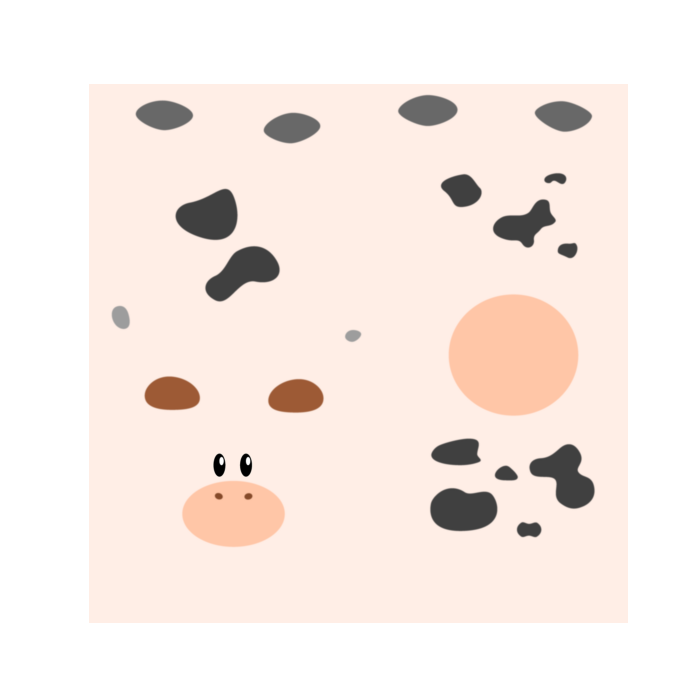

In [4]:
plt.figure(figsize=(7,7))
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.grid("off");
plt.axis('off');

In [5]:
# Initialize an OpenGL perspective camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 

# gives extrinsics T
# gives extrinsics R
R, T = look_at_view_transform(3, 0, 90) 

print(R)
print(T)
# R = np.float32([
#     [0, 0, -1], 
#     [0, 1, 0], 
#     [1, 0, 0]])
# T = np.float32([-2, 0, 0])
# R, T = look_at_view_transform(2.7, 0, 180) 
# T = -R.dot(T)
# R = torch.from_numpy(R).unsqueeze(0)
# T = torch.from_numpy(T).unsqueeze(0)
cameras = OpenGLPerspectiveCameras(device=device, R=R.transpose(1,2), T=T)

cx = 0.0
cy = 0.0
fx = 1.0
fy = 1.0
principal_point = np.array([cx, cy]).astype(np.float32)
principal_point = torch.from_numpy(principal_point).unsqueeze(0)
focal_length = np.array([fx, fy]).astype(np.float32)
focal_length = torch.from_numpy(focal_length).unsqueeze(0)

# cameras = SfMPerspectiveCameras(device=device, R=R, T=T, focal_length=focal_length, principal_point=principal_point)
camR = cameras.R
camT = cameras.T

print(camR)
print(camT)

tensor([[[ 4.3711e-08, -0.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [-1.0000e+00,  0.0000e+00,  4.3711e-08]]])
tensor([[-0., -0., 3.]])
tensor([[[ 4.3711e-08,  0.0000e+00, -1.0000e+00],
         [-0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 1.0000e+00,  0.0000e+00,  4.3711e-08]]], device='cuda:0')
tensor([[-0., -0., 3.]], device='cuda:0')


[autoreload of pytorch3d.renderer.mesh.rasterize_meshes failed: Traceback (most recent call last):
  File "C:\Users\hjoon\AppData\Local\Continuum\anaconda3\envs\pytorch3d\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\hjoon\AppData\Local\Continuum\anaconda3\envs\pytorch3d\lib\site-packages\IPython\extensions\autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\hjoon\AppData\Local\Continuum\anaconda3\envs\pytorch3d\lib\site-packages\IPython\extensions\autoreload.py", line 347, in update_generic
    update(a, b)
  File "C:\Users\hjoon\AppData\Local\Continuum\anaconda3\envs\pytorch3d\lib\site-packages\IPython\extensions\autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "C:\Users\hjoon\AppData\Local\Continuum\anaconda3\envs\pytorch3d\lib\site-packages\IPython\extensions\autoreload.py", line 347, in update_generic
 

<IPython.core.display.Javascript object>


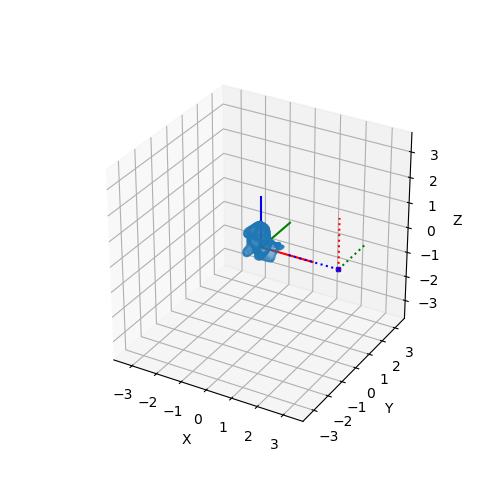

[ 3.0000000e+00  0.0000000e+00 -1.3113416e-07] == [ 3.0000000e+00 -0.0000000e+00 -1.3113416e-07]


In [8]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

# camera
t = T.squeeze().cpu().numpy()
r = R.squeeze().cpu().numpy()

# to pose
t = -r.T.dot(t)
# t = -r.dot(t)
r = r.T

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vs[:,0], vs[:,1], vs[:,2], s=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
L = max(np.max(t)*1.2, 2)
ax.set_xlim([-L, L])
ax.set_ylim([-L, L])
ax.set_zlim([-L, L])
L = 2
ax.plot([0, L], [0, 0], [0, 0], c='r')
ax.plot([0, 0], [0, L], [0, 0], c='g')
ax.plot([0, 0], [0, 0], [0, L], c='b')

ax.scatter(t[0], t[1], t[2], c='r', s=10)
cam_pos = cameras.get_camera_center().squeeze().cpu().numpy()
ax.scatter(cam_pos[0], cam_pos[1], cam_pos[2], c='b', marker='x', s=10)
print(cam_pos, '==', t)
Xc_axis = t + r.dot(np.float32([L, 0, 0]))
Yc_axis = t + r.dot(np.float32([0, L, 0]))
Zc_axis = t + r.dot(np.float32([0, 0, L]))
ax.plot([t[0], Xc_axis[0]], [t[1], Xc_axis[1]], [t[2], Xc_axis[2]], c='r', linestyle=':')
ax.plot([t[0], Yc_axis[0]], [t[1], Yc_axis[1]], [t[2], Yc_axis[2]], c='g', linestyle=':')
ax.plot([t[0], Zc_axis[0]], [t[1], Zc_axis[1]], [t[2], Zc_axis[2]], c='b', linestyle=':')
plt.show()


In [9]:
# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size = None,  # this setting controls whether naive or coarse-to-fine rasterization is used
    max_faces_per_bin = None  # this setting is for coarse rasterization
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

images = renderer(mesh)
plt.figure(figsize=(5, 5))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.show()

TypeError: descriptor 'image_size' for 'RasterizationSettings' objects doesn't apply to a 'RasterizationSettings' object